# Facebook + Twitter Topic Modeling using Mallet LDA
    Break down posts into sentences

# Instructions to run this Notebook

This Notebook was created in a Python 3.6 environment.

All the libraries are installed with pip. When the code fails to run, just google how to install the missing library. 

The only special case is the spacy library. You need to run the command window as Administrator and then run pip. 
If you still get this error:
OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.
You need to run this as Adminnistrator
 python -m spacy link en_core_web_sm en

The dataset used in this Notebook can be downloaded from Teams folder "5-Data Analytics and Results"

I glued together code from several places, but the bulk of the code came from here:
https://www.tutorialspoint.com/gensim/gensim_creating_lda_topic_model.htm


# Parameters to run this Notebook

In [1]:
input_file_name = "Step1_Shape_Raw_Data.xlsx"
#input_sheet_name = "Twitter_Clean"
#input_sheet_name = "Facebook_Clean"
input_sheet_name = "Combined_Clean"




Fix error in 
nlp = spacy.load('en')
OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.


Run as Administrator: python -m spacy link en_core_web_sm en
    

In [2]:
import base64
import numpy as np
import pandas as pd
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 100000) # Extend the display width to prevent split functions to not cover full text

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
#from scipy.misc import imread  deprecated. Import imread from imageio instead

from imageio import imread

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.style as style 
%matplotlib inline


# Libraries for gensim and spacy
import json
import glob
from tqdm.notebook import tqdm
from textblob import TextBlob

import spacy # Leading library for NLP
nlp = spacy.load('en')

import re
import string

import gensim
from gensim import matutils, models
import scipy.sparse

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk

#from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import matplotlib.pyplot as plt



# 1. Load and Inspect the Dataset

In [3]:
# Loading in the Social Media Postsdata with Pandas

dfInput = pd.read_excel(input_file_name, sheet_name=input_sheet_name)

In [4]:
dfInput.head(10)

,Source,Date,Text,Shares,Likes,Comments
0,1,2020-02-01,update on the 2019 novel coronavirus (ncov) - ...,52,54,4.0
1,1,2020-02-01,as of 1 february 2020 2pm we have confirmed 2 ...,151,122,14.0
2,1,2020-02-02,as of 2 february 2020 2pm we have not been not...,118,311,32.0
3,1,2020-02-03,minister for health gan kim yong delivered a m...,40,85,25.0
4,1,2020-02-03,as of 3 february 2020 2pm we have not been not...,54,185,13.0
5,1,2020-02-04,as of 4 february 2020 2pm we have confirmed si...,131,276,154.0
6,1,2020-02-04,as of 4 february 12pm 289 of the suspect cases...,42,88,19.0
7,1,2020-02-05,from temperature screenings at changi airport ...,15,73,22.0
8,1,2020-02-05,the straits times spoke to experts in singapor...,58,85,54.0
9,1,2020-02-06,“we are cleaning the escalator hand rails lift...,36,341,23.0


# Word frequency BEFORE cleaning the text

In [5]:
all_words = dfInput['Text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies input dataset ' + input_sheet_name
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Prepare text for LDA Analysis

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['covid', 'covid-19', 'read', 'link', 'http', 'https'])
stop_words.extend(['covid', 'covid-19', 'https', 'http'])

# Split  posts into separate sentences
    More important for Facebook, but probably does not harm Twitter posts either

In [7]:
from nltk.tokenize import sent_tokenize

dfPosts = pd.DataFrame()
for index, row in dfInput.iterrows():
    # Split the Facebook post into sentences 
    tokenized_text=sent_tokenize(row["Text"])
    seq = 0
    for sentence in tokenized_text:
        seq = seq + 1 # sentence sequence
        dfPosts = dfPosts.append(pd.Series([row["Source"], row["Date"], index, seq, sentence, row["Shares"], row["Likes"], row["Comments"]]), ignore_index=True)

dfPosts.columns = ["Source","Date","Post_id","Sentence_id","Text","Shares","Likes","Comments"]

In [8]:
# Fix numeric datatypes back to Integers
dfPosts.Source = dfPosts.Source.astype(int)
dfPosts.Post_id = dfPosts.Post_id.astype(int)
dfPosts.Sentence_id = dfPosts.Sentence_id.astype(int)
dfPosts.Shares = dfPosts.Shares.fillna(0)
dfPosts.Likes = dfPosts.Likes.fillna(0)
dfPosts.Comments = dfPosts.Comments.fillna(0)

dfPosts.Shares = dfPosts.Shares.astype(int)
dfPosts.Likes = dfPosts.Likes.astype(int)
dfPosts.Comments = dfPosts.Comments.astype(int)


In [9]:
dfPosts.head(5)

,Source,Date,Post_id,Sentence_id,Text,Shares,Likes,Comments
0,1,2020-02-01,0,1,update on the 2019 novel coronavirus (ncov) - ...,52,54,4
1,1,2020-02-01,0,2,there is no need to avoid places where persons...,52,54,4
2,1,2020-02-01,0,3,there is also currently no evidence of communi...,52,54,4
3,1,2020-02-01,1,1,as of 1 february 2020 2pm we have confirmed 2 ...,151,122,14
4,1,2020-02-01,1,2,16 confirmed cases were earlier announced by m...,151,122,14


Start clean up from Original Text

In [10]:
def sent_to_words(sentences):
   for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #deacc=True removes punctuation

original_texts = dfPosts['Text']        
data_words = list(sent_to_words(original_texts))


In [17]:
#data_words

Building Bigram & Trigram Models 

In [11]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Filter out stop words

In [12]:
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc))
    if word not in stop_words] for doc in texts]

def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
   return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
     doc = nlp(" ".join(sent))
     texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

Clean and Lemmatize text, using Trigrams


From tune-facebook-sentences Notebook, we already know we want to analize only NOUNS

In [13]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)


#nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN'])

#data_lemmatized_verbs = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'VERB'])
#data_lemmatized_all = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



# Build input for LDA Models

In [14]:
# Build input for LDA models
from gensim.corpora.dictionary import Dictionary

# Option 1 - Just Nouns
id2word = Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# Option 2 - Nouns and Verbs
#id2word_v = Dictionary(data_lemmatized_verbs)
#texts_v = data_lemmatized_verbs
#corpus_v = [id2word_v.doc2bow(text) for text in texts_v]

# Option 3 - Nouns,Verbs, Adjectives, Adverbs
#id2word_a = Dictionary(data_lemmatized_all)
#texts_a = data_lemmatized_all
#corpus_a = [id2word_a.doc2bow(text) for text in texts_a]





In [15]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('case', 1),
  ('list', 1),
  ('message', 1),
  ('place', 1),
  ('rumour', 1),
  ('whatsapp', 1)]]

# Use Mallet LDA implementation
    We already benchmarked Mallet vs Gensim implementation in Notebook tune-facebook-sentences

In [16]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

# Create a few Models to compare Coherence Score by Number of Topics

   Look for number of Topics with Highest Coherence Score

In [19]:
from gensim.models import CoherenceModel
def coherence_values_computation(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, random_seed=100)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(
          model=model, texts=texts, dictionary=dictionary, coherence='c_v' )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [20]:
limit=50; start=3; step=3;

# Calculate model coherence with Nouns only
model_list_n, coherence_values_n = coherence_values_computation (
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=start, limit=limit, step=step
)



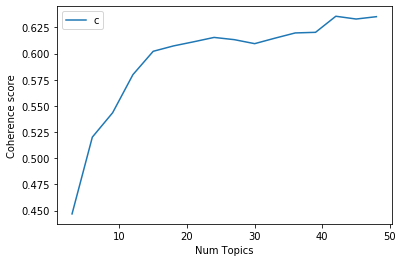

In [21]:
x = range(start, limit, step)
plt.plot(x, coherence_values_n)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
for m, cv in zip(x, coherence_values_n):
   print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4467
Num Topics = 6  has Coherence Value of 0.5201
Num Topics = 9  has Coherence Value of 0.5435
Num Topics = 12  has Coherence Value of 0.5799
Num Topics = 15  has Coherence Value of 0.6022
Num Topics = 18  has Coherence Value of 0.6074
Num Topics = 21  has Coherence Value of 0.6113
Num Topics = 24  has Coherence Value of 0.6155
Num Topics = 27  has Coherence Value of 0.6133
Num Topics = 30  has Coherence Value of 0.6095
Num Topics = 33  has Coherence Value of 0.6148
Num Topics = 36  has Coherence Value of 0.6198
Num Topics = 39  has Coherence Value of 0.6204
Num Topics = 42  has Coherence Value of 0.6357
Num Topics = 45  has Coherence Value of 0.6331
Num Topics = 48  has Coherence Value of 0.6353


# Selecting Number of Topics 

Nouns only:
Num Topics = 42  has Coherence Value of 0.6357

42 topics seems un-manageable. Let's reduce it to 15 
Num Topics = 15  has Coherence Value of 0.6022
       

In [40]:
ldamallet_n = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=15, id2word=id2word, random_seed=100)

coherence_model_mallet = CoherenceModel(
   model=ldamallet_n, texts=data_lemmatized, dictionary=id2word, coherence='c_v'
)
coherence_score_mallet_n = coherence_model_mallet.get_coherence()
print('\nCoherence Score Mallet Nouns: ', coherence_score_mallet_n)

#ldamallet_n.show_topics()



Coherence Score Mallet Nouns:  0.6022145988089945


In [41]:
for topic_id in range(ldamallet_n.num_topics):
    topk = ldamallet_n.show_topic(topic_id, 30)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id +1, '|'.join(topk_words))) # Add 1 to topic id so our export matches the Intertopic Distance Map

1: case|resident|end|practitioner|friend|laboratory|approach|action|family_member|polyclinic|progress|update|touch|practise|rumour|space|minute|treatment|transport|block|male|mid|experience|apparatus|timeline|nudge|commitment|turn|backbone|quarter
2: hospital|facility|community|isolation|singaporean|clinic|d_to|precaution|population|enabler|safety|nation|end|disorder|adjustment|personal_hygiene|cruise|necessity|baby|grant|rebound|accessibility|concern|point|appreciation|tcm|therapy|claim|format|flaring
3: care|unit|condition|ability|case|singapore|wear|arrangement|ambassador|fee|population|brand|clearance|patient|tuition|bay|system|mom|simplifie|protect|oxygen|budget|tireless|ring|respond|study|approval|proof|dorscon|website
4: infection|case|movement|checkpoint|employer|call|source|addition|people|sport|responsibility|enhance|suspension|firm|implementation|position|list|matter|treatment|migrant|distribution|working|focus|emergence|massage|pair|spa|national|officer|pcr
5: case|dorm|com

# Final selection: Model with Nouns, 15 topics


# Save Topics

Once Model is Selected, add topics to dataframe and save as CSV

In [42]:
# rest of Notebook code refers to lda_model variable. Let's just reassign it to the ldamallet_n model
lda_model = ldamallet_n


# Add all topic contributions to dataframe

In [43]:
# LDA corpus contains the topic pct ditributions per text
# Make sure all topics are present in all text rows

for i, row in enumerate(lda_model[corpus]):
    print (row)

[(0, 0.08333333333333336), (1, 0.059523809523809514), (2, 0.059523809523809514), (3, 0.07539682539682542), (4, 0.059523809523809514), (5, 0.059523809523809514), (6, 0.08134920634920637), (7, 0.059523809523809514), (8, 0.07738095238095241), (9, 0.059523809523809514), (10, 0.07738095238095241), (11, 0.06150793650793649), (12, 0.06547619047619048), (13, 0.059523809523809514), (14, 0.06150793650793649)]
[(0, 0.061302681992337155), (1, 0.057471264367816084), (2, 0.057471264367816084), (3, 0.06513409961685825), (4, 0.06513409961685825), (5, 0.07854406130268202), (6, 0.06513409961685825), (7, 0.07471264367816094), (8, 0.06321839080459771), (9, 0.057471264367816084), (10, 0.09195402298850577), (11, 0.0881226053639847), (12, 0.05938697318007662), (13, 0.057471264367816084), (14, 0.057471264367816084)]
[(0, 0.061728395061728406), (1, 0.08024691358024696), (2, 0.061728395061728406), (3, 0.061728395061728406), (4, 0.06378600823045269), (5, 0.0637860082304527), (6, 0.061728395061728406), (7, 0.0946

[(0, 0.06535947712418301), (1, 0.06535947712418301), (2, 0.06535947712418301), (3, 0.07625272331154687), (4, 0.06535947712418301), (5, 0.06535947712418301), (6, 0.06753812636165576), (7, 0.06535947712418301), (8, 0.06971677559912855), (9, 0.06535947712418301), (10, 0.06535947712418301), (11, 0.06535947712418301), (12, 0.06753812636165576), (13, 0.06535947712418301), (14, 0.06535947712418301)]
[(0, 0.06172839506172837), (1, 0.06172839506172837), (2, 0.06172839506172837), (3, 0.06378600823045266), (4, 0.06790123456790122), (5, 0.11728395061728394), (6, 0.06790123456790122), (7, 0.06172839506172837), (8, 0.06378600823045266), (9, 0.06172839506172837), (10, 0.06172839506172837), (11, 0.06172839506172837), (12, 0.06378600823045266), (13, 0.06172839506172837), (14, 0.06172839506172837)]
[(0, 0.0641025641025641), (1, 0.0641025641025641), (2, 0.0641025641025641), (3, 0.07264957264957266), (4, 0.06623931623931624), (5, 0.0641025641025641), (6, 0.0747863247863248), (7, 0.0641025641025641), (8, 0

In [44]:
dfAll_topics = pd.DataFrame()
new_corpus = lda_model[corpus]
for topic_id in range(lda_model.num_topics):
    str_topic_id = str(topic_id+1)
    #dfAll_topics['topic_' + str_topic_id] = pd.Series([a[topic_id][0] for a in lda_model[corpus]])
    dfAll_topics['topic_' + str_topic_id + '_pct'] = pd.Series([a[topic_id][1] for a in new_corpus])

In [45]:
dfAll_topics.head(5)

,topic_1_pct,topic_2_pct,topic_3_pct,topic_4_pct,topic_5_pct,topic_6_pct,topic_7_pct,topic_8_pct,topic_9_pct,topic_10_pct,topic_11_pct,topic_12_pct,topic_13_pct,topic_14_pct,topic_15_pct
0,0.083333,0.059524,0.059524,0.075397,0.059524,0.059524,0.081349,0.059524,0.077381,0.059524,0.077381,0.061508,0.065476,0.059524,0.061508
1,0.061303,0.057471,0.057471,0.065134,0.065134,0.078544,0.065134,0.074713,0.063218,0.057471,0.091954,0.088123,0.059387,0.057471,0.057471
2,0.061728,0.080247,0.061728,0.061728,0.063786,0.063786,0.061728,0.094650,0.061728,0.061728,0.061728,0.061728,0.061728,0.063786,0.078189
3,0.068376,0.064103,0.064103,0.072650,0.068376,0.064103,0.070513,0.064103,0.070513,0.064103,0.064103,0.064103,0.072650,0.064103,0.064103
4,0.079060,0.064103,0.064103,0.072650,0.070513,0.064103,0.072650,0.064103,0.064103,0.064103,0.064103,0.064103,0.064103,0.064103,0.064103


# Find Dominant Topic

In [46]:
dfDominant = pd.DataFrame()
for i, row in enumerate(lda_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True) # sort topics to obtain highest score
    #print(row)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0: #  dominant topic, after sorting by contribution
            wp = lda_model.show_topic(topic_num)
            dom_topic = topic_num + 1 # again, add 1 so topic numbers match Intertopic Distance Map
            #print(wp)
            topic_keywords = "| ".join([word for word, prop in wp])
            #print(topic_keywords)
            dfDominant = dfDominant.append( pd.Series([dom_topic, prop_topic, topic_keywords]), ignore_index=True)
        else:
            break
dfDominant.columns = ['Dominant_Topic', 'Dominant_Pct', 'Dominant_Topic_Keywords']

In [47]:
dfDominant.Dominant_Topic = dfDominant.Dominant_Topic.astype(int)
dfDominant.head(5)

,Dominant_Topic,Dominant_Pct,Dominant_Topic_Keywords
0,1,0.083333,case| resident| end| friend| practitioner| lab...
1,11,0.091954,day| place| patient| worker| shn| number| trav...
2,8,0.094650,measure| transmission| risk| health| virus| si...
3,4,0.072650,infection| case| movement| checkpoint| employe...
4,1,0.079060,case| resident| end| friend| practitioner| lab...


In [48]:
dfDominant.groupby('Dominant_Topic').count()

,Dominant_Pct,Dominant_Topic_Keywords
Dominant_Topic,,
1,446,446
2,174,174
3,254,254
4,296,296
5,118,118
6,195,195
7,155,155
8,175,175
9,162,162


# Add Topic Scores to Data Frame

In [33]:
#dfPosts.head()

In [49]:
dfClassified = dfPosts.copy()
dfClassified = dfClassified.join(dfDominant)
dfClassified = dfClassified.join(dfAll_topics)

In [50]:
dfClassified.head(5)

,Source,Date,Post_id,Sentence_id,Text,Shares,Likes,Comments,Dominant_Topic,Dominant_Pct,...,topic_6_pct,topic_7_pct,topic_8_pct,topic_9_pct,topic_10_pct,topic_11_pct,topic_12_pct,topic_13_pct,topic_14_pct,topic_15_pct
0,1,2020-02-01,0,1,update on the 2019 novel coronavirus (ncov) - ...,52,54,4,1,0.083333,...,0.059524,0.081349,0.059524,0.077381,0.059524,0.077381,0.061508,0.065476,0.059524,0.061508
1,1,2020-02-01,0,2,there is no need to avoid places where persons...,52,54,4,11,0.091954,...,0.078544,0.065134,0.074713,0.063218,0.057471,0.091954,0.088123,0.059387,0.057471,0.057471
2,1,2020-02-01,0,3,there is also currently no evidence of communi...,52,54,4,8,0.094650,...,0.063786,0.061728,0.094650,0.061728,0.061728,0.061728,0.061728,0.061728,0.063786,0.078189
3,1,2020-02-01,1,1,as of 1 february 2020 2pm we have confirmed 2 ...,151,122,14,4,0.072650,...,0.064103,0.070513,0.064103,0.070513,0.064103,0.064103,0.064103,0.072650,0.064103,0.064103
4,1,2020-02-01,1,2,16 confirmed cases were earlier announced by m...,151,122,14,1,0.079060,...,0.064103,0.072650,0.064103,0.064103,0.064103,0.064103,0.064103,0.064103,0.064103,0.064103


In [52]:
#dfClassified.groupby(['Dominant_Topic', 'Source']).count()

# Save the classified dataframe to CSV

In [53]:
#output_file_name = "Twitter_with_topics.csv"
output_file_name = "Combined_sentences_mallet_15_topics.csv"

dfClassified.to_csv(output_file_name)